In [2]:
import os
import glob

data_dir = "./"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create dog in training
dog_training_dir = os.path.join(training_dir,"dog")
if not os.path.isdir(dog_training_dir):
  os.mkdir(dog_training_dir)

#create cat in training
cat_training_dir = os.path.join(training_dir,"cat")
if not os.path.isdir(cat_training_dir):
  os.mkdibr(cat_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
dog_validation_dir = os.path.join(validation_dir,"dog")
if not os.path.isdir(dog_validation_dir):
  os.mkdir(dog_validation_dir)

#create cat in validation
cat_validation_dir = os.path.join(validation_dir,"cat")
if not os.path.isdir(cat_validation_dir):
  os.mkdir(cat_validation_dir)

In [4]:
import shutil

split_size = 0.80
cat_imgs_size = len(glob.glob("./not_stop/*"))
dog_imgs_size = len(glob.glob("./stop/*"))

for i,img in enumerate(glob.glob("./not_stop/*")):
  if i < (cat_imgs_size * split_size):
    shutil.move(img,cat_training_dir)
  else:
    shutil.move(img,cat_validation_dir)

for i,img in enumerate(glob.glob("./stop/*")):
  if i < (dog_imgs_size * split_size):
    shutil.move(img,dog_training_dir)
  else:
    shutil.move(img,dog_validation_dir)

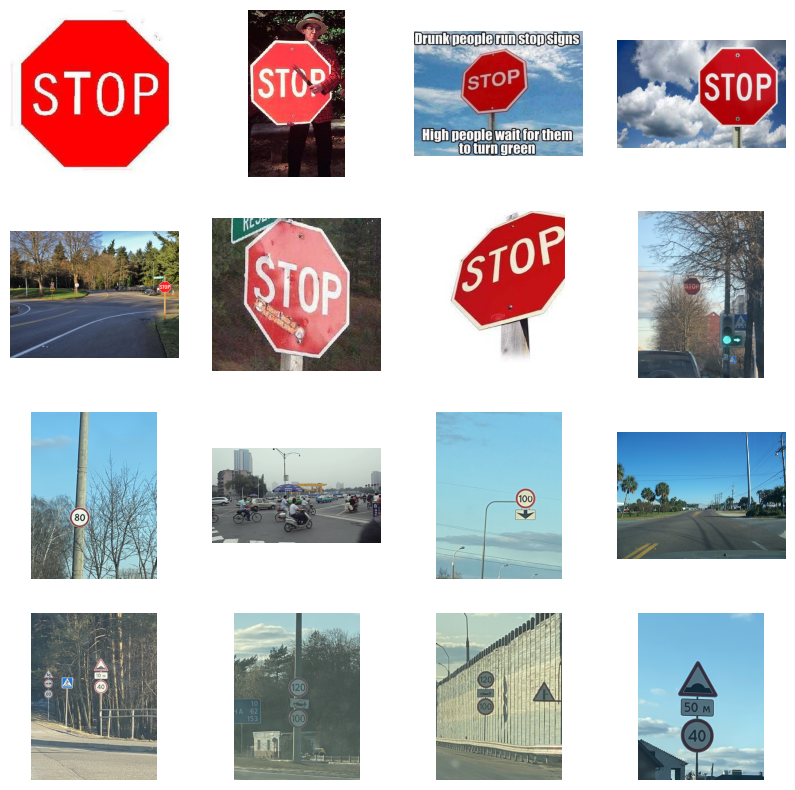

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from IPython.core.pylabtools import figsize

samples_dog = [os.path.join(dog_training_dir,np.random.choice(os.listdir(dog_training_dir),1)[0]) for _ in range(8)]
samples_cat = [os.path.join(cat_training_dir,np.random.choice(os.listdir(cat_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_dog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_cat[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms

traindir = "./training/"
testdir = "./validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [8]:
import torch
import torchvision
from torchvision import datasets, transforms

traindir = "./training/"
testdir = "./validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [9]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

/home/mllabs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mllabs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mllabs/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 30.2MB/s]


In [10]:
torch.cuda.is_available()

True

In [12]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [13]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [14]:
%%capture
!pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Non Stop


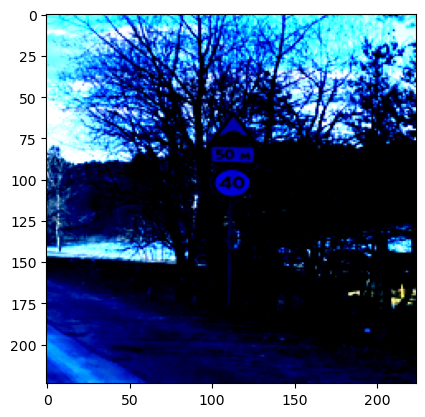

In [17]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Non Stop")
  else:
    print("Prediction : Stop")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Stop


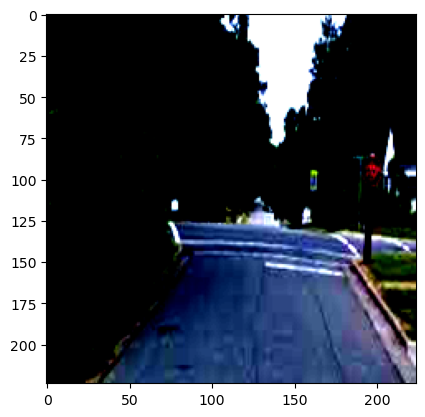

In [18]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Non Stop")
  else:
    print("Prediction : Stop")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Stop


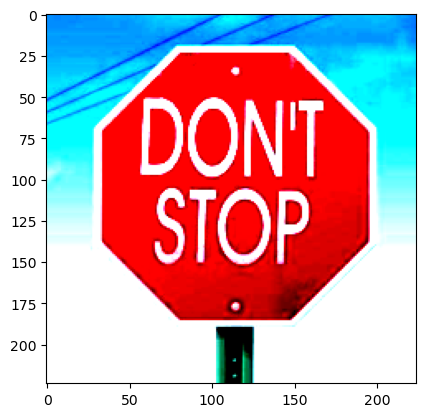

In [53]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Non Stop")
  else:
    print("Prediction : Stop")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)